# Prediction of the corona virus

This notebook contains some basic predictions of the corona virus.

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
import datetime 
figsize = (12, 9)

In [2]:
import pandas as pd
import glob

In [3]:
def sigmoid(x, x0, k, L):
     y = L / (1 + np.exp(-k*(x-x0)))
     return y

def exp(x):
    return np.exp(x)

Save confirmed cases and deaths into data frames

In [4]:
dataframes = []
for f in glob.glob("time_series_covid19_confirmed_global.csv"):
    dataframes.append(pd.read_csv(f))
df = pd.concat(dataframes)

df = df.drop(columns=['Lat', 'Long', 'Province/State'])
df = df.T
df = df.rename(columns=df.iloc[0])
df = df.drop('Country/Region')
df['date'] = df.index

dataframes = []
for f in glob.glob("time_series_covid19_deaths_global.csv"):
    dataframes.append(pd.read_csv(f))
df_deaths = pd.concat(dataframes)

df_deaths = df_deaths.drop(columns=['Lat', 'Long', 'Province/State'])
df_deaths = df_deaths.T
df_deaths = df_deaths.rename(columns=df_deaths.iloc[0])
df_deaths = df_deaths.drop('Country/Region')
df_deaths['date'] = df_deaths.index

# Prediction new cases

In [5]:
def predict(country, prediction_length = 30):
    
    center_average_length = 7 # should be an odd number
    prediction_length = prediction_length+int((center_average_length+1)/2)
    
    # sum provinces into one country
    try:
        sum_doubles = df[country].sum(1)
    except:
        sum_doubles = df[country]

    confirmed = sum_doubles.to_numpy()
    
    new_cases = confirmed[1:]-confirmed[:-1]
    average_length = 7 # in days
    growth_factor = np.zeros(len(new_cases))
    for i in range(len(new_cases)-1):
        if new_cases[i] == 0:
            grwoth_factor = 0
        else:
            growth_factor[i+1] = new_cases[i+1]/new_cases[i]
    growth_factor_averaged = np.zeros(len(growth_factor))
    for i in range(len(growth_factor)-average_length):
        growth_factor_averaged[i+average_length] = np.mean(growth_factor[i:i+average_length])
    new_cases_averaged = np.zeros(len(new_cases))
    for i in range(len(new_cases)-average_length):
        new_cases_averaged[i+average_length] = np.mean(new_cases[i:i+average_length])

    #Prediction
    fit_length = 5

    #compare different fits - curve fit with exp seams to work well
    #growth_averaged_p, residuals, rank, singular_values, rcond = np.polyfit(np.arange(0,fit_length),growth_averaged[-fit_length:],1, full=True)
    #growth_averaged_p_exp, residuals_exp, rank, singular_values, rcond = np.polyfit(np.arange(0,fit_length),np.log(growth_averaged[-fit_length:]),1, full=True)
    #residuals_exp = np.sum((np.exp(np.polyval(growth_averaged_p_exp, np.arange(0,fit_length))) - growth_averaged[-fit_length:])**2)
    #print('residuals',residuals,'residuals exp',residuals_exp, 'difference', (residuals-residuals_exp)/residuals)
    exp_function = lambda t,a,b: a*np.exp(b*t)
    new_cases_averaged_p_exp = curve_fit(exp_function, np.arange(0,fit_length), new_cases_averaged[-fit_length:],bounds=([-10**10,-1], [10**10, 0.2]))[0]

    
    #growth_averaged_fit = np.poly1d(growth_averaged_p)
    #growth_averaged_prediction = growth_averaged_fit(np.arange(0,prediction_length+fit_length))
    #growth_averaged_fit = np.poly1d(growth_averaged_p_exp)
    #growth_averaged_prediction = np.exp(growth_averaged_fit(np.arange(0,prediction_length+fit_length)))
    new_cases_averaged_prediction = exp_function(np.arange(0,prediction_length+fit_length),new_cases_averaged_p_exp[0],new_cases_averaged_p_exp[1])
    for i in range(len(new_cases_averaged_prediction)-fit_length):
        if new_cases_averaged_prediction[i+fit_length] < new_cases_averaged_prediction[0+fit_length]/10:
            new_cases_averaged_prediction[i+fit_length] = new_cases_averaged_prediction[0+fit_length]/10
          
    new_cases_and_averaged_prediction = np.zeros(len(new_cases_averaged)+prediction_length)
    new_cases_and_averaged_prediction[:len(new_cases_averaged)] = new_cases_averaged
    new_cases_and_averaged_prediction[len(new_cases_averaged):] = new_cases_averaged_prediction[-prediction_length:]
    
    #calculate backwards from the average to daily numbers
    new_cases_and_prediction = np.zeros(len(new_cases)+prediction_length)
    
    for i in range(len(new_cases_and_prediction)-average_length):
        
        new_cases_and_prediction[i+average_length] = new_cases_and_averaged_prediction[i+average_length]*average_length-np.sum(new_cases_and_prediction[i+1:i+average_length])

    #comupte a center average of the new cases and the predicted new cases
    
    new_cases_and_prediction_center_averaged = np.zeros(len(new_cases_and_prediction)-int((center_average_length-1)/2)-1)
    for i in range(len(new_cases_and_prediction)-center_average_length):
        new_cases_and_prediction_center_averaged[i+int((center_average_length-1)/2)] = np.mean(new_cases_and_prediction[i:i+center_average_length])
         
    # sum the predicted new cases center averaged numbers to the confirmed predicted numbers      
    confirmed_predicted = np.zeros(len(new_cases_and_prediction_center_averaged)-fit_length)
    for i in range(prediction_length-int((center_average_length-1)/2)-1):
        if i == 0:
            confirmed_predicted[i] = confirmed[-1] + new_cases_and_prediction_center_averaged[i+len(date)-1]
        else:
            confirmed_predicted[i] = confirmed_predicted[i-1] + new_cases_and_prediction_center_averaged[i+len(date)-1]
            
    confirmed_predicted = confirmed_predicted.astype(int)

    """
    fig, ax = plt.subplots()
    plt.plot(x_date[1:len(date)],new_cases,'o')
    plt.plot(x_date[1:len(date)],new_cases_averaged,'o')
    plt.plot(x_date[len(date)-fit_length:len(date)+prediction_length],new_cases_averaged_prediction,'r.')
    plt.plot(x_date[0:len(new_cases_and_prediction)],new_cases_and_prediction,'.')
    #plt.plot(x_date[len(date)-fit_length:len(date)],np.exp(np.polyval(new_cases_averaged_p_exp, np.arange(0,fit_length))),'.')
    plt.xlabel('date')
    plt.ylabel('new cases averaged past '+ str(average_length)+' days')
    plt.title(country)
    plt.xticks(rotation='vertical')
    plt.show()"""
    
    return confirmed_predicted, confirmed

In [6]:

countries = df.columns
countries = countries.drop_duplicates() 
countries = countries[:-1] #drop date column
#countries = countries[:2]
date = df['date'].to_numpy()
today = datetime.date.today()
x_date = []
length = 150
for i in range(length):
    x_date.append(datetime.datetime(2020, 1, 22)+ datetime.timedelta(days=i) )

prediction_length = 30
confirmed_and_predicted = np.zeros((len(countries),len(date)+prediction_length))

for i in range(len(countries)): 
    country = countries[i]
    confirmed_predicted, confirmed = predict(country, prediction_length)
    for j in range(len(date)):
        confirmed_and_predicted[i,j] = confirmed[j]
    for j in range(prediction_length):
        confirmed_and_predicted[i,j+len(date)] = confirmed_predicted[j]
        
    #print(country,'t+2',confirmed_predicted[1],'t+7',confirmed_predicted[6],'t+30',confirmed_predicted[29])

    """
    fig = plt.figure()
    plt.plot(x_date[:len(date)],confirmed,'.')
    #plt.plot(x_date,y, label='fit')
    plt.plot(x_date[:len(date)+prediction_length],confirmed_and_predicted[i],'.', label='prediction')
    plt.xlabel('date')
    plt.xticks( rotation='vertical')
    plt.ylabel('confirmed')
    plt.title(country)   
    plt.show()"""
    
#create df of confirmed and predicted cases
confirmed_and_predicted = pd.DataFrame(data=confirmed_and_predicted.T,columns=countries.to_numpy())  

"""
fig = plt.figure()
plt.plot(x_date[:len(date)],confirmed,'.')
#plt.plot(x_date,y, label='fit')
plt.plot(x_date[len(date):len(date)+prediction_length],confirmed_predicted,'.', label='prediction')
plt.xlabel('date')
plt.xticks( rotation='vertical')
plt.ylabel('confirmed')
plt.title(country)   
plt.show()

fig = plt.figure()
plt.plot(date[1:],growth,'.')
plt.xticks(locs[::every_nth])
plt.xlabel('date')
plt.ylabel('growth')
plt.title(country)

fig = plt.figure()
plt.plot(confirmed[1:],growth_averaged,'.')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('confirmed')
plt.ylabel('growth averaged past '+ str(average_length)+' days')
plt.title(country)

fig, ax = plt.subplots()
plt.plot(x_date[1:len(date)],growth_averaged,'o')
plt.plot(x_date[len(date)-fit_length:len(date)+prediction_length],growth_averaged_prediction,'.')
#plt.plot(x_date[len(date)-fit_length:len(date)],np.exp(np.polyval(growth_averaged_p_exp, np.arange(0,fit_length))),'.')
every_nth = 10
locs, labels = plt.xticks()
plt.xticks(locs[::every_nth])
plt.xlabel('date')
plt.ylabel('growth averaged past '+ str(average_length)+' days')
plt.title(country)

fig, ax = plt.subplots()
plt.plot(date[1:],growth_factor,'.')
every_nth = 10
locs, labels = plt.xticks()
plt.axhline(1, color='r')
plt.xticks(locs[::every_nth])
plt.xlabel('date')
plt.ylabel('growth factor')
plt.title(country)

fig, ax = plt.subplots()
plt.plot(date[1:],growth_factor_averaged,'.')
every_nth = 10
locs, labels = plt.xticks()
plt.axhline(1, color='r')
plt.xticks(locs[::every_nth])
plt.xlabel('date')
plt.ylabel('growth factor averaged past '+ str(average_length)+' days')
plt.title(country)
"""

'\nfig = plt.figure()\nplt.plot(x_date[:len(date)],confirmed,\'.\')\n#plt.plot(x_date,y, label=\'fit\')\nplt.plot(x_date[len(date):len(date)+prediction_length],confirmed_predicted,\'.\', label=\'prediction\')\nplt.xlabel(\'date\')\nplt.xticks( rotation=\'vertical\')\nplt.ylabel(\'confirmed\')\nplt.title(country)   \nplt.show()\n\nfig = plt.figure()\nplt.plot(date[1:],growth,\'.\')\nplt.xticks(locs[::every_nth])\nplt.xlabel(\'date\')\nplt.ylabel(\'growth\')\nplt.title(country)\n\nfig = plt.figure()\nplt.plot(confirmed[1:],growth_averaged,\'.\')\nplt.xscale("log")\nplt.yscale("log")\nplt.xlabel(\'confirmed\')\nplt.ylabel(\'growth averaged past \'+ str(average_length)+\' days\')\nplt.title(country)\n\nfig, ax = plt.subplots()\nplt.plot(x_date[1:len(date)],growth_averaged,\'o\')\nplt.plot(x_date[len(date)-fit_length:len(date)+prediction_length],growth_averaged_prediction,\'.\')\n#plt.plot(x_date[len(date)-fit_length:len(date)],np.exp(np.polyval(growth_averaged_p_exp, np.arange(0,fit_length

# Predict Deaths by solving an inverse problem

**Define the function for grid search**

In [7]:
# Grid search
def findDeathLatencyAndMortality(country):
    
    # sum provinces into one country
    try:
        sum_doubles = df_deaths[country].sum(1)
    except:
        sum_doubles = df_deaths[country]
        
    average_length = 7 # in days, has to be uneven
    deaths = sum_doubles.to_numpy()
    confirmed_and_predicted_array = confirmed_and_predicted[country].to_numpy()
    new_cases = confirmed_and_predicted_array[1:]-confirmed_and_predicted_array[:-1]
    new_cases_averaged = np.zeros(len(new_cases)-int((average_length-1)/2)-1) # here take center average instead of forward averaging
    for i in range(len(new_cases)-average_length):
        new_cases_averaged[i+int((average_length-1)/2)] = np.mean(new_cases[i:i+average_length])
        
    new_deaths = deaths[1:]-deaths[:-1]
    new_deaths_averaged = np.zeros(len(new_deaths)-int((average_length-1)/2)-1) # here take center average instead of forward averaging
    for i in range(len(new_deaths)-average_length):
        new_deaths_averaged[i+int((average_length-1)/2)] = np.mean(new_deaths[i:i+average_length])
            
    # Use grid search to find death latency and mortality
    # March through all possible time shifts. --------------------------
    
    # Set the noise level.
    noise_level=2
    
    # Test time shifts in days.
    delta=np.arange(1.0,20.0,1)

    # Test mortailities.
    mortalities=np.arange(0.001,0.5,0.001)
    
    # Initialise posterior distribution.
    p=np.zeros((len(delta),len(mortalities)))
    

    # March through all possible time shifts.
    for n in range(len(delta)):
        death_latency = int(delta[n])
        # March through all possible time shifts.
        for m in range(len(mortalities)):
            mortality = mortalities[m]
            # Make test time series by shifting new_cases_averaged.
            s = np.zeros(len(new_deaths_averaged))
            s[death_latency:] = new_cases_averaged[:len(new_deaths_averaged)-death_latency]*mortality
            """
            fig = plt.figure()
            plt.plot(x_date[1:len(s)+1],s,'.',label='s')
            plt.plot(x_date[1:len(new_deaths_averaged)+1],new_deaths_averaged,'.',label='new deaths averaged'+str(n)+str(mortality))
            plt.xlabel('date')
            plt.ylabel('new deaths')
            plt.xticks(rotation='vertical')
            plt.grid(True)
            plt.legend()
            plt.title(country)
            plt.show() """

            # Evaluate posterior.
            p[n,m]=prior_data(s,new_deaths_averaged,noise_level)


    # Normalise distribution.
    #p=p/(0.01*np.sum(p))

    # Plot posterior. --------------------------------------------------
    
    plt.pcolor(mortalities,delta,p, cmap=plt.cm.get_cmap('binary'))
    plt.xlabel(r'mortalities')
    plt.ylabel(r'death latency')
    plt.colorbar()
    plt.title('posterior probability density')
    plt.grid()
    plt.show()
    
    death_latency_index, mortality_index = np.where(p == np.amax(p))
    death_latency, mortality = int(delta[death_latency_index]), mortalities[mortality_index]
    print(death_latency, mortality)
    print(deaths[-1])
    print(confirmed_and_predicted_array[-death_latency-prediction_length])
    print(deaths[-1]/confirmed_and_predicted_array[-death_latency-prediction_length])
    
    return death_latency, mortality

In [8]:
# Define the prior in data space. ----------------------------------
def prior_data(s1,s2,noise_level):
    p=np.sum((s1-s2)**2)/(len(s1)*noise_level**2)
    return np.exp(-p/2.0)
 

    
def predict_deaths(country, prediction_length = 30, death_latency=9, mortality=0.054):
    
    # sum provinces into one country
    try:
        sum_doubles = df_deaths[country].sum(1)
    except:
        sum_doubles = df_deaths[country]
        
    average_length = 7 # in days, has to be uneven
    deaths = sum_doubles.to_numpy()
    confirmed_and_predicted_array = confirmed_and_predicted[country].to_numpy()
    new_cases = confirmed_and_predicted_array[1:]-confirmed_and_predicted_array[:-1]
    new_cases_averaged = np.zeros(len(new_cases)-int((average_length-1)/2)-1) # here take center average instead of forward averaging
    for i in range(len(new_cases)-average_length):
        new_cases_averaged[i+int((average_length-1)/2)] = np.mean(new_cases[i:i+average_length])
        
    new_deaths = deaths[1:]-deaths[:-1]
    new_deaths_averaged = np.zeros(len(new_deaths)-int((average_length-1)/2)-1) # here take center average instead of forward averaging
    for i in range(len(new_deaths)-average_length):
        new_deaths_averaged[i+int((average_length-1)/2)] = np.mean(new_deaths[i:i+average_length])
        
    index_of_today = len(df['date'])
    
    new_deaths_predicted = new_cases[index_of_today-death_latency:]*mortality
    
    deaths_predicted = np.zeros(prediction_length)
    for i in range(prediction_length):
        if i == 0:
            deaths_predicted[i] = deaths[-1] + new_deaths_predicted[i]
        else:
            deaths_predicted[i] = deaths_predicted[i-1] + new_deaths_predicted[i]
            
    new_cases_manipulated = np.zeros(len(date)+prediction_length)
    new_cases_manipulated[death_latency:] = new_cases_averaged[:len(date)+prediction_length-death_latency]*mortality
    new_cases_manipulated_summed = np.zeros(len(date)+prediction_length)
    for i in range(len(new_cases_manipulated)-1):
        new_cases_manipulated_summed[i+1] = new_cases_manipulated_summed[i] + new_cases_manipulated[i+1]

    deaths_predicted = deaths_predicted.astype(int)
    """
    fig = plt.figure()
    plt.plot(x_date[1:len(new_deaths)+1],new_deaths,'.',label='new deaths')
    plt.plot(x_date[1:len(new_deaths_averaged)+1],new_deaths_averaged,'.',label='new deaths averaged')
    #plt.plot(x_date[1:len(new_cases_manipulated)+1],new_cases_manipulated,'.',label='new cases manipulated')
    plt.xlabel('date')
    plt.ylabel('new deaths')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.legend()
    plt.title(country)
    plt.show() 
    
    fig = plt.figure()
    plt.plot(x_date[1:len(new_cases)+1],new_cases,'.',label='new cases')
    plt.plot(x_date[1:len(new_cases_averaged)+1],new_cases_averaged,'.',label='new cases averaged')
    plt.xlabel('date')
    plt.ylabel('new cases')
    plt.xticks(rotation='vertical')
    plt.legend()
    plt.grid(True)
    plt.title(country)
    plt.show()
    plt.savefig('new_cases.pdf')"""
    
    return deaths_predicted, deaths, new_cases_manipulated_summed

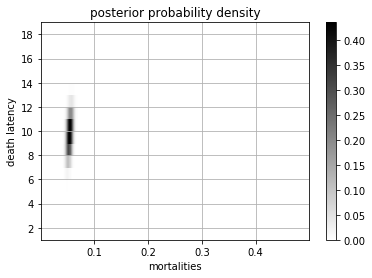

9 [0.054]
1281
23280.0
0.05502577319587629


C:\Users\stefa\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


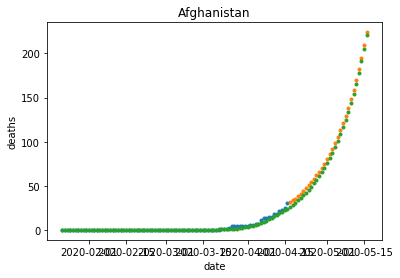

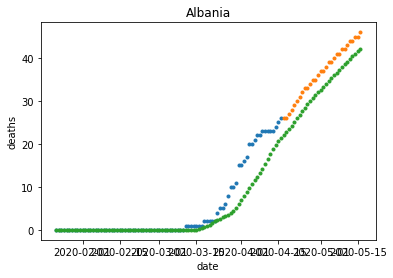

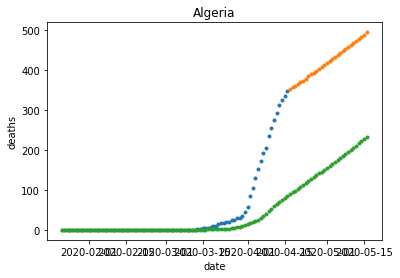

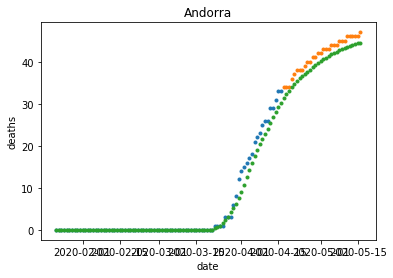

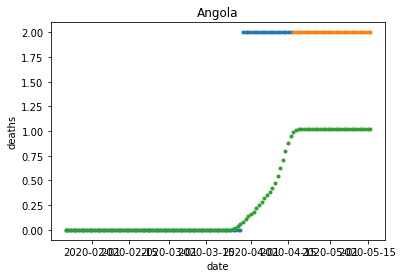

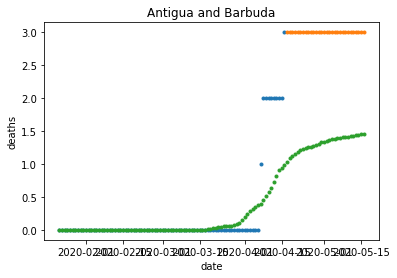

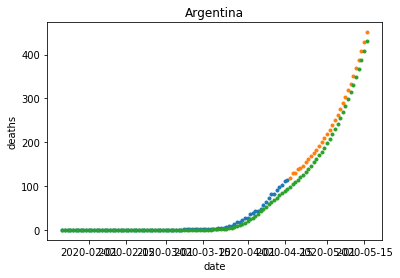

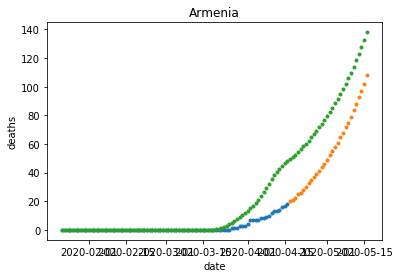

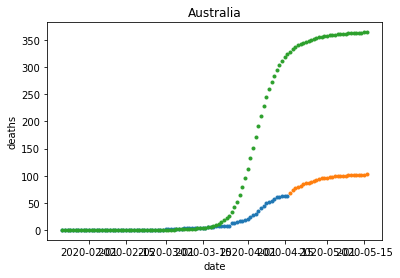

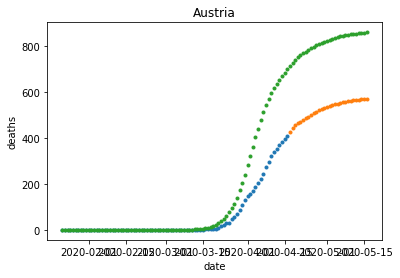

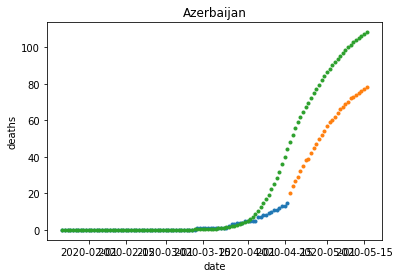

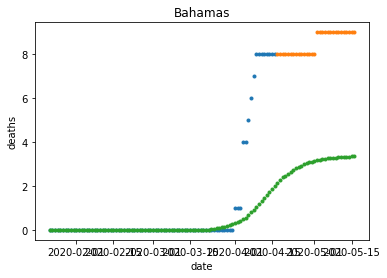

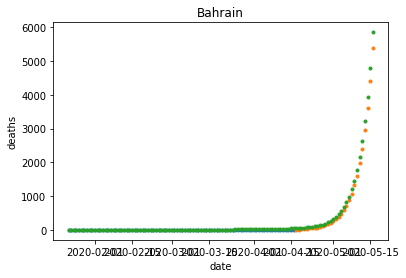

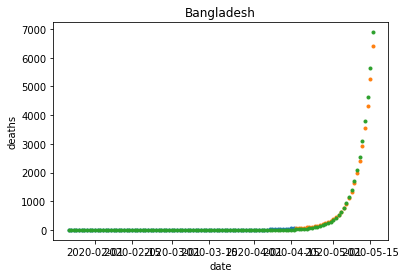

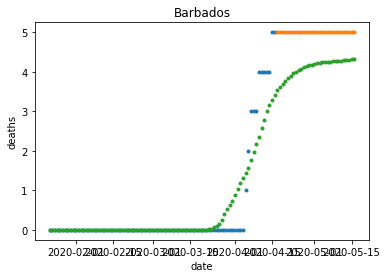

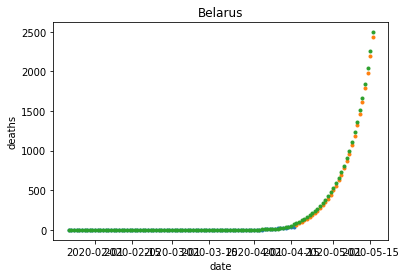

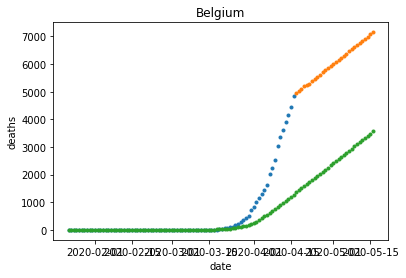

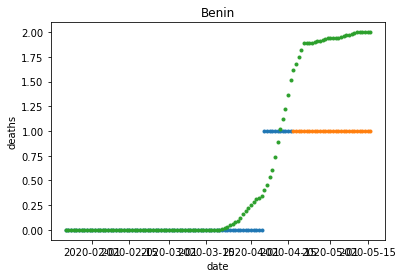

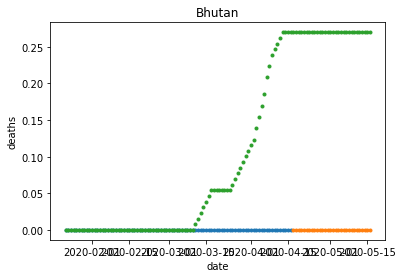

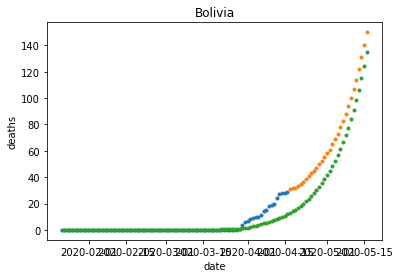

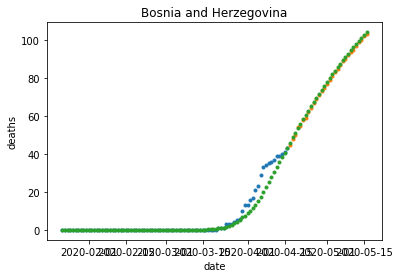

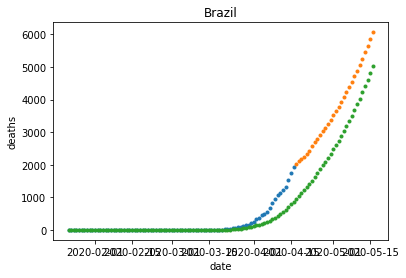

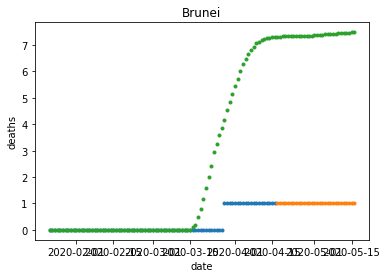

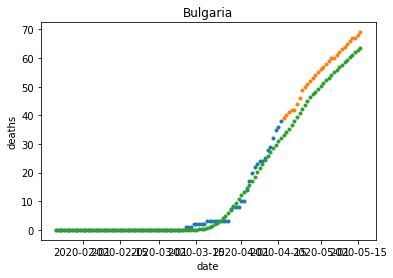

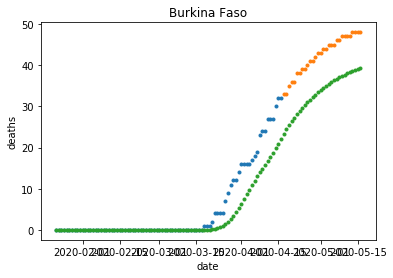

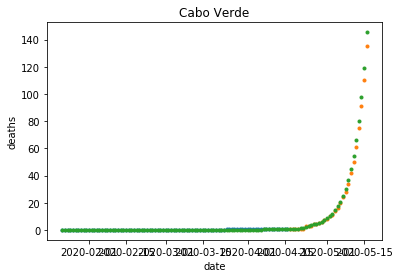

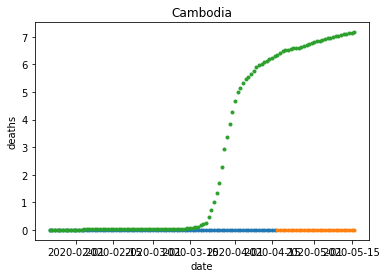

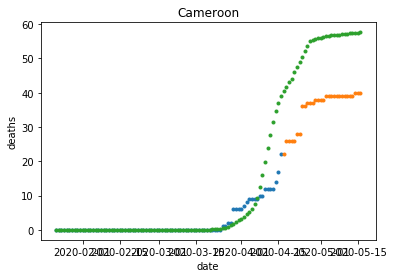

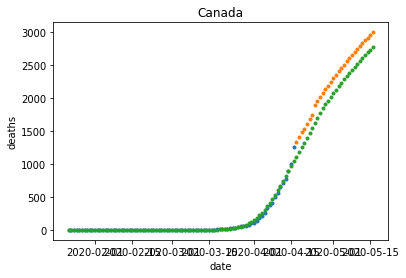

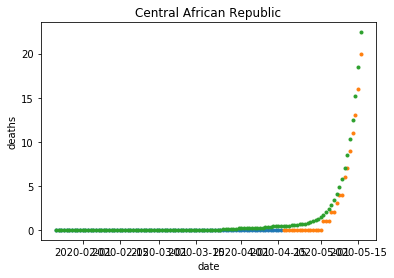

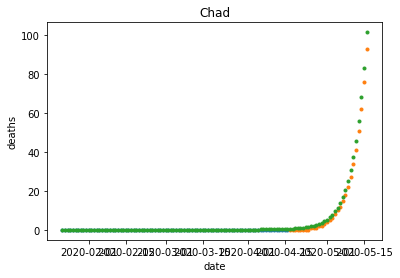

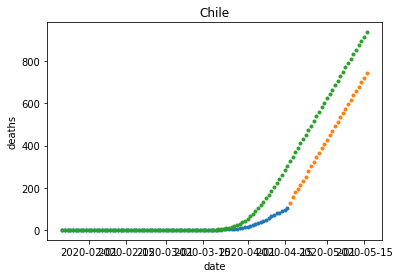

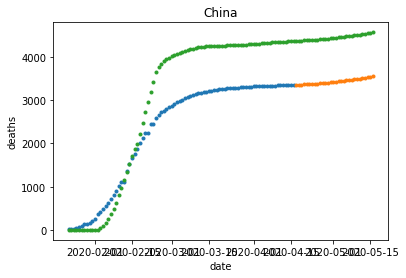

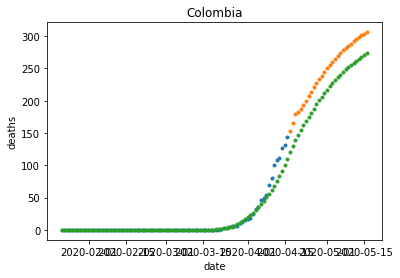

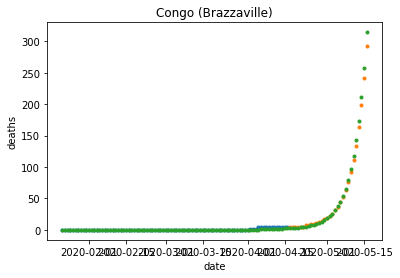

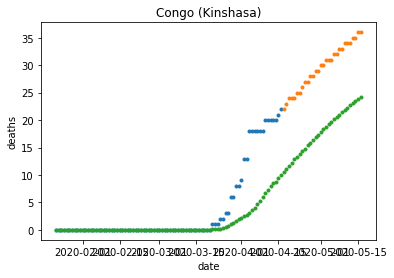

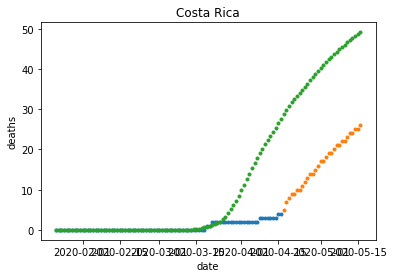

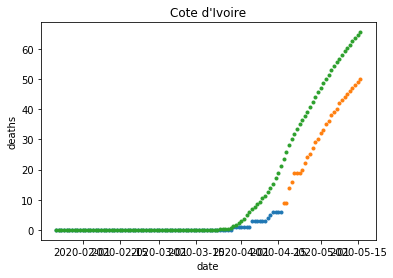

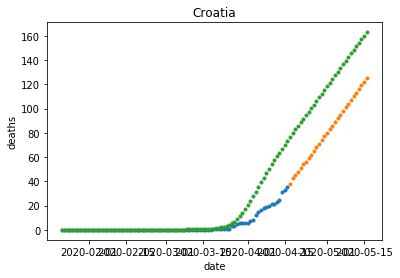

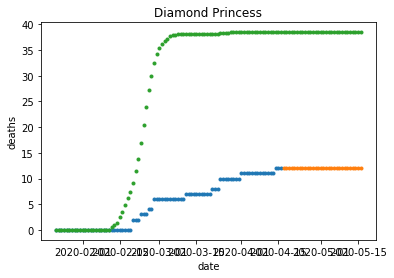

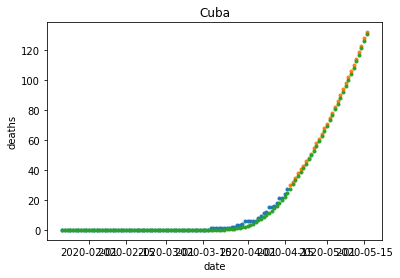

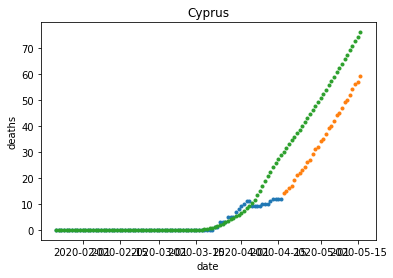

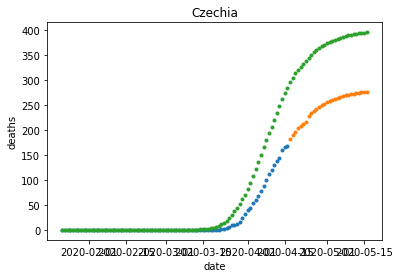

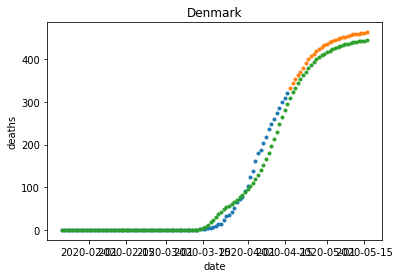

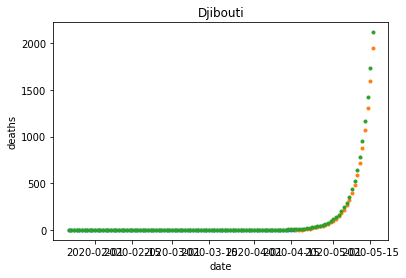

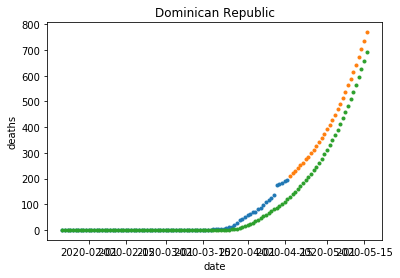

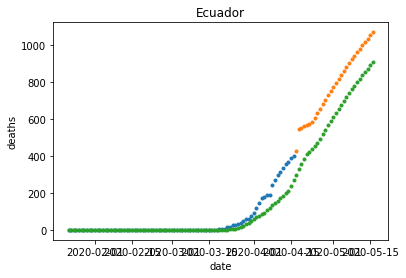

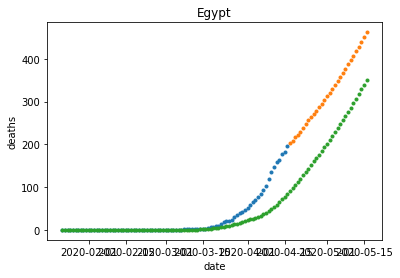

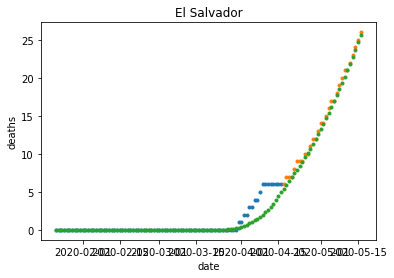

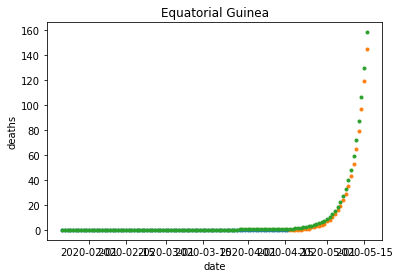

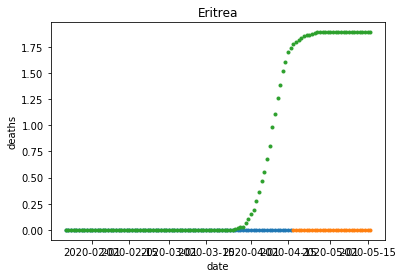

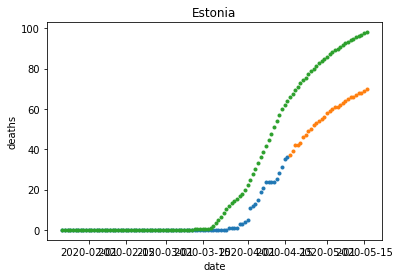

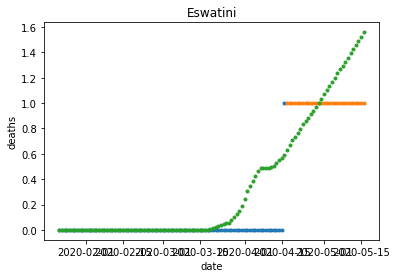

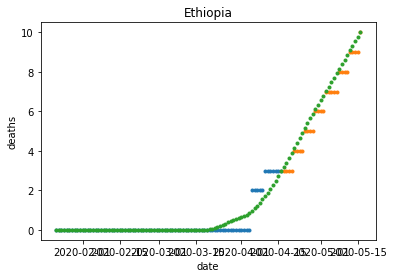

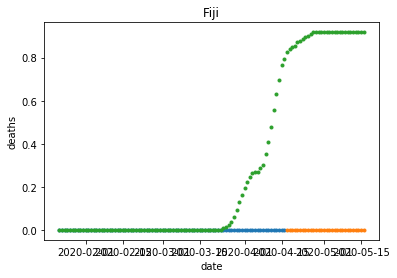

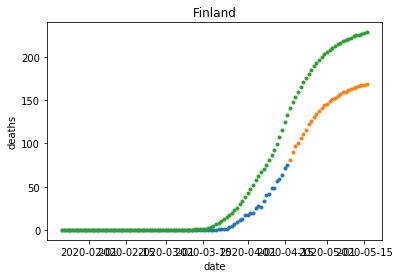

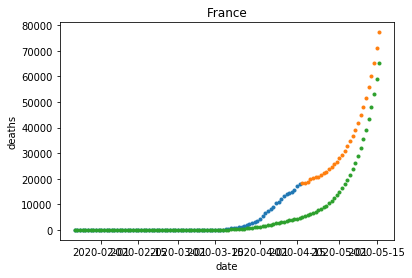

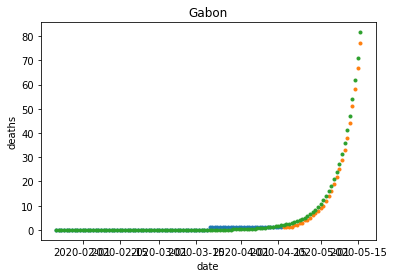

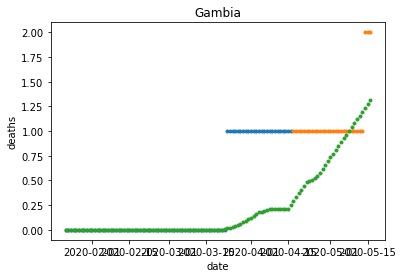

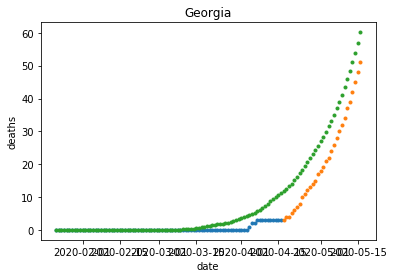

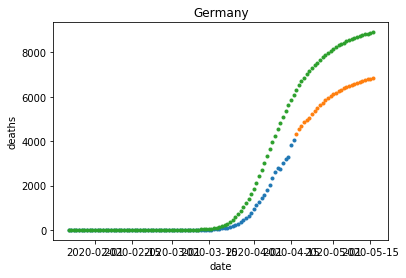

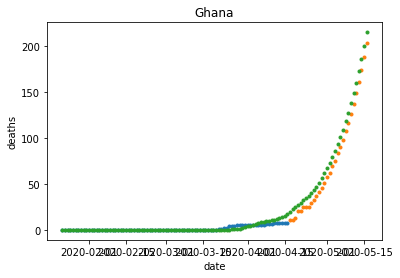

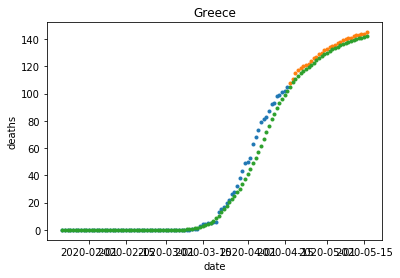

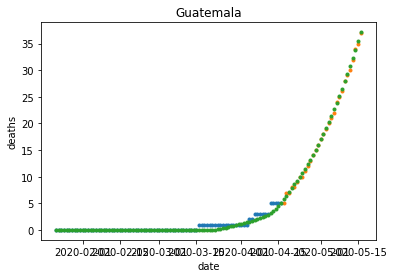

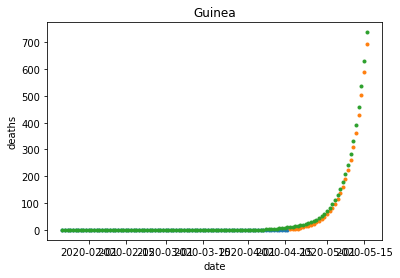

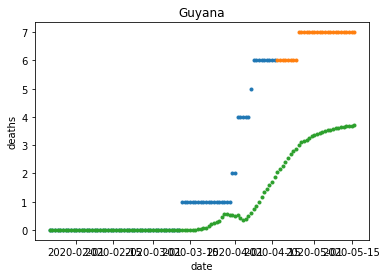

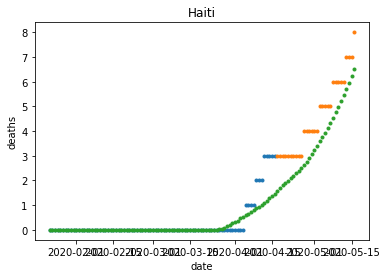

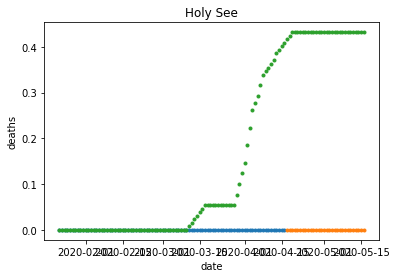

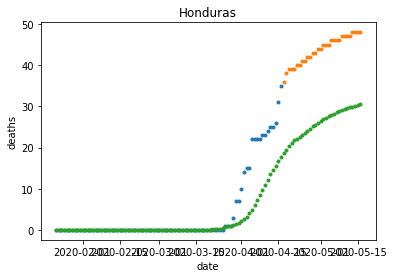

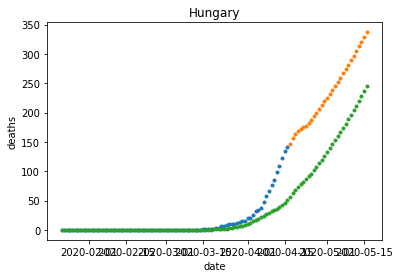

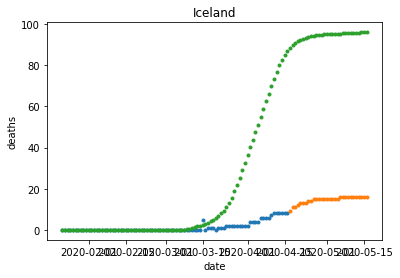

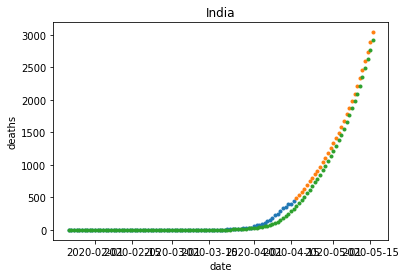

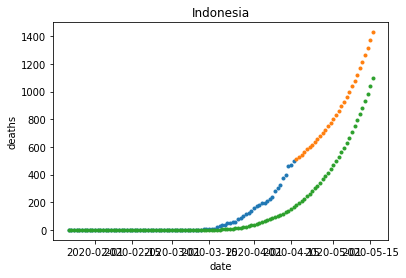

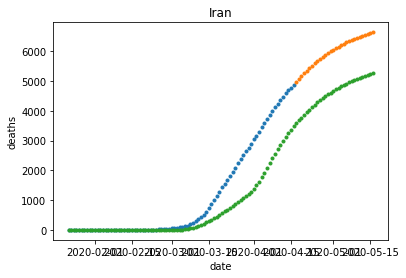

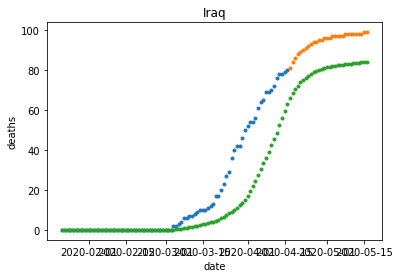

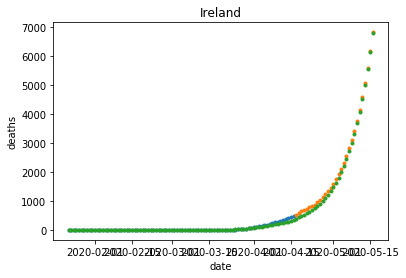

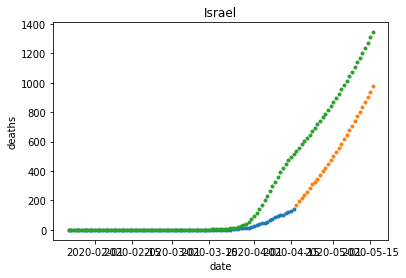

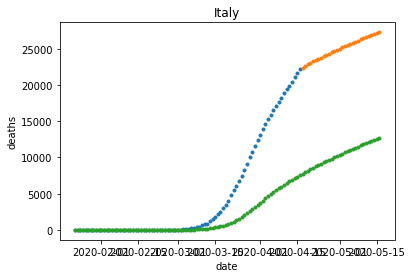

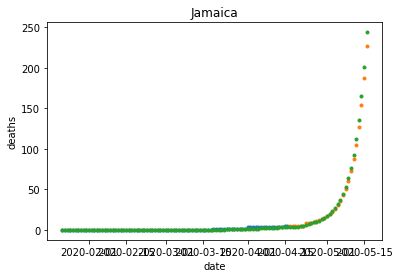

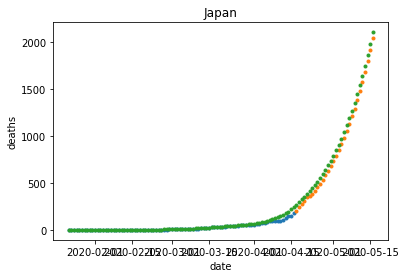

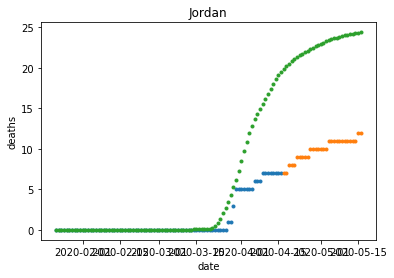

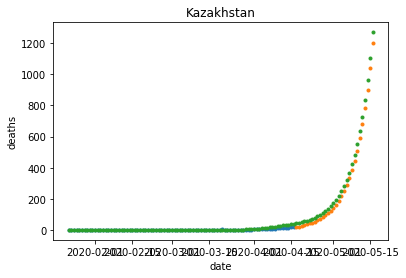

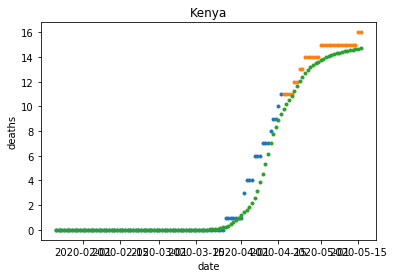

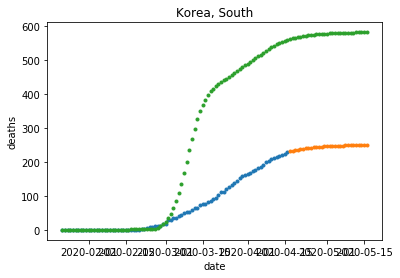

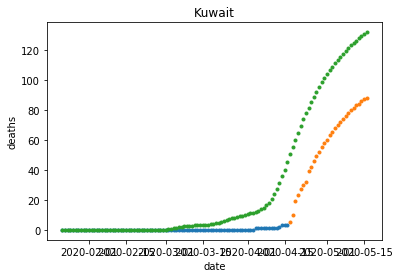

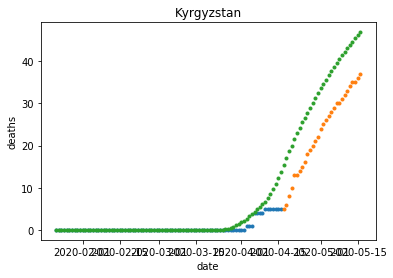

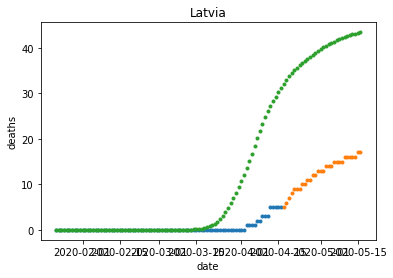

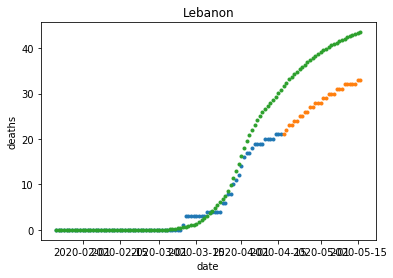

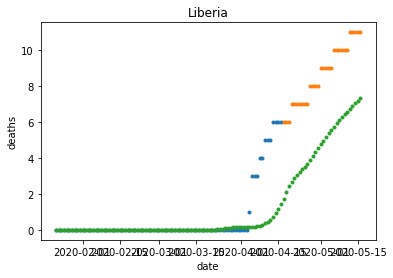

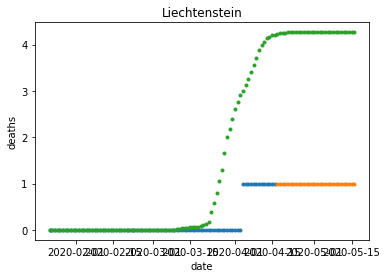

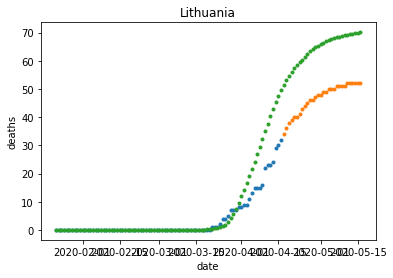

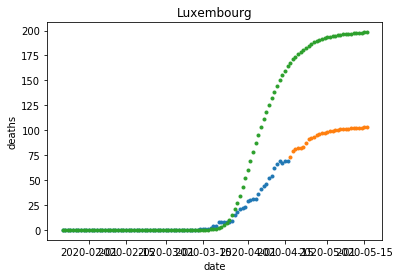

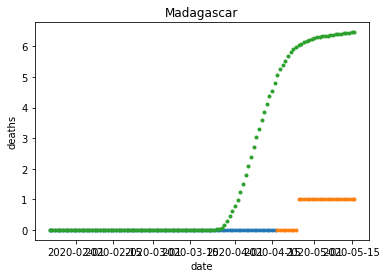

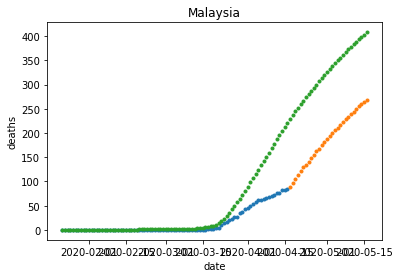

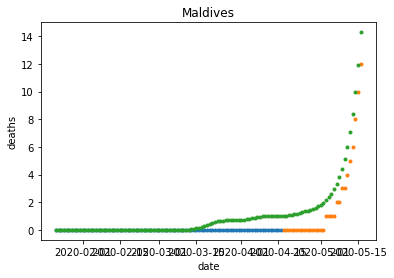

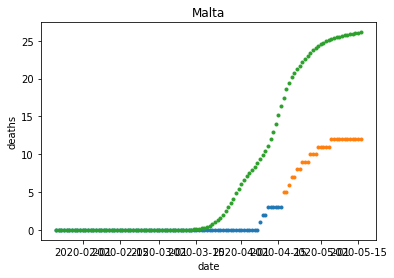

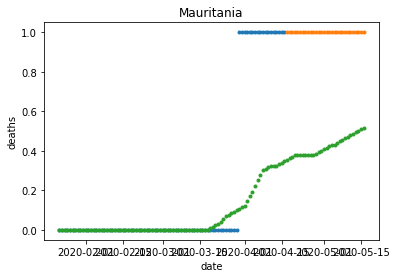

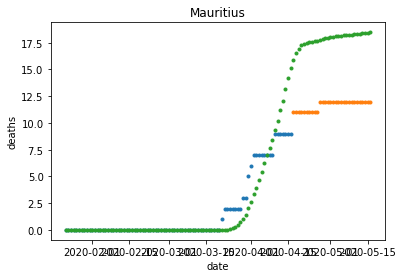

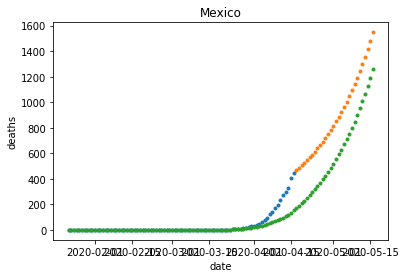

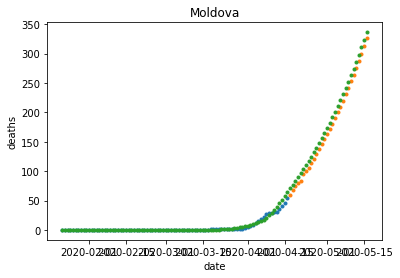

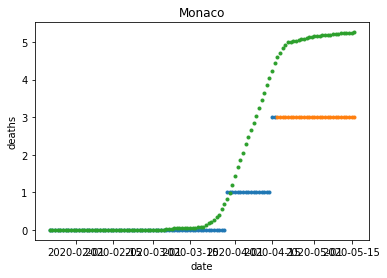

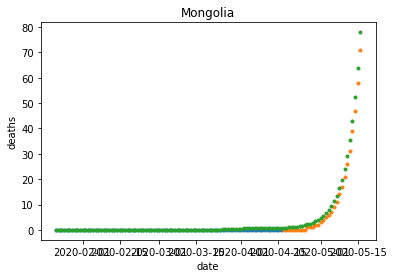

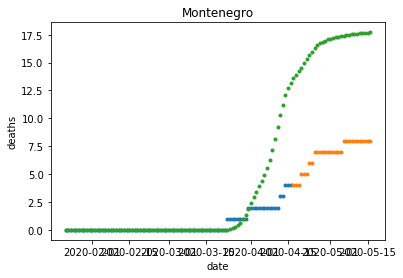

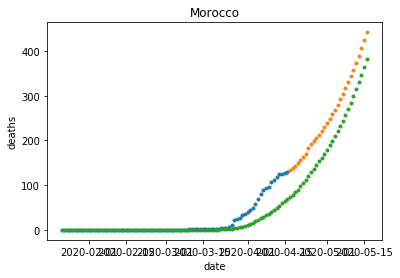

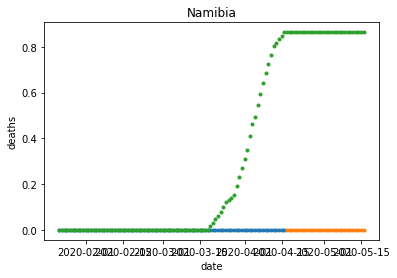

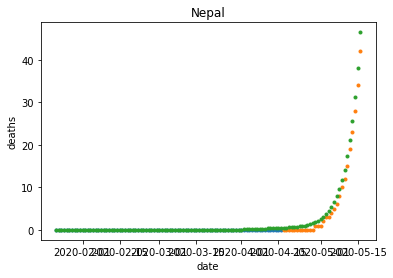

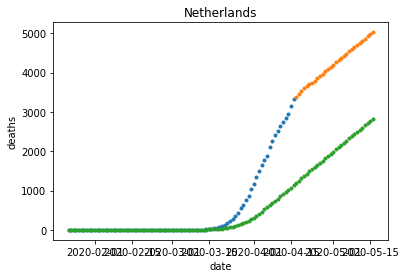

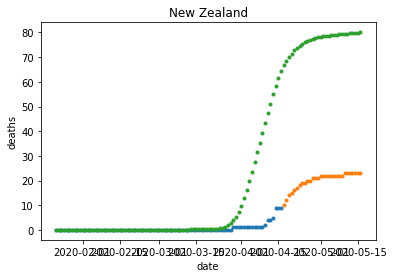

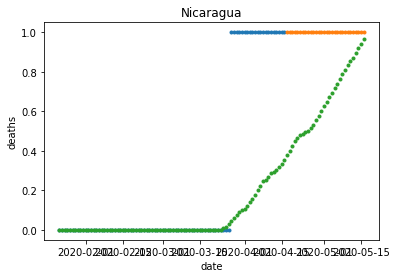

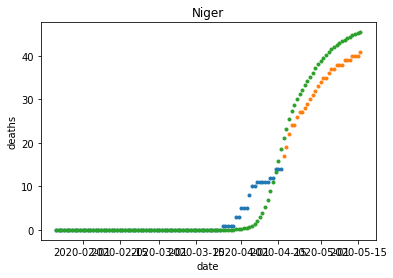

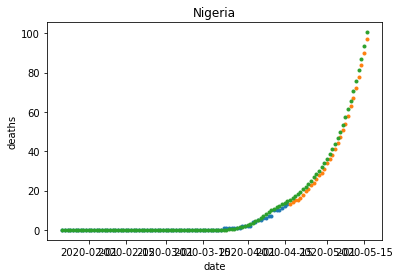

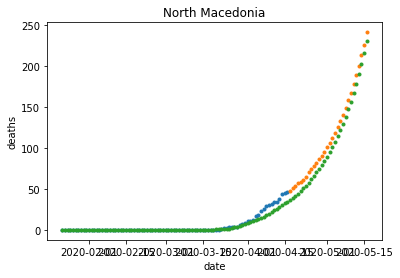

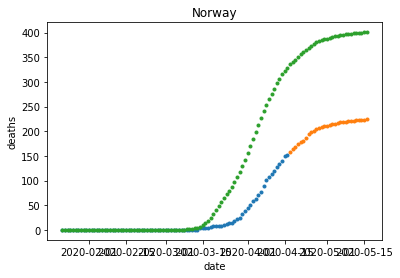

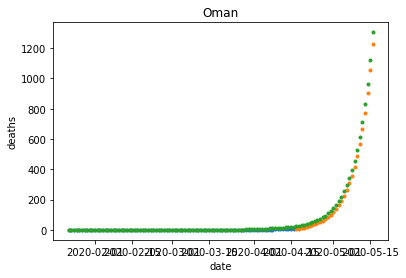

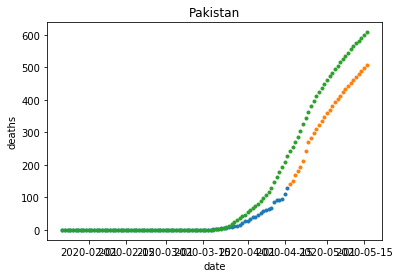

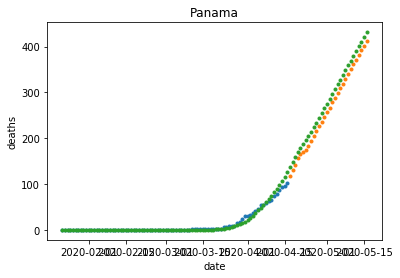

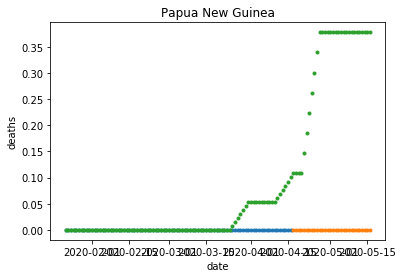

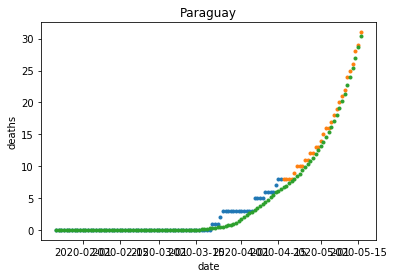

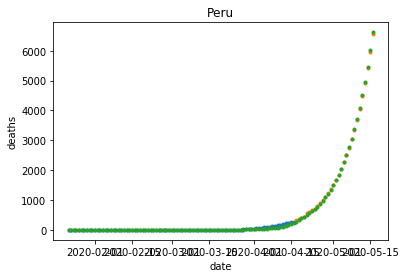

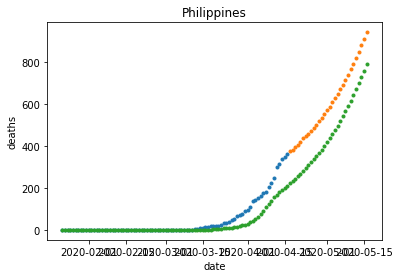

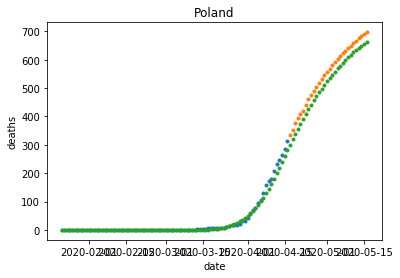

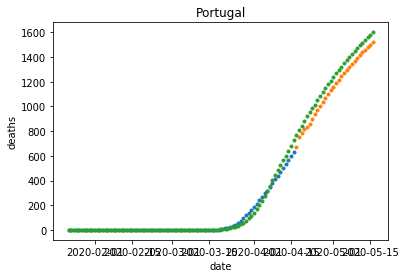

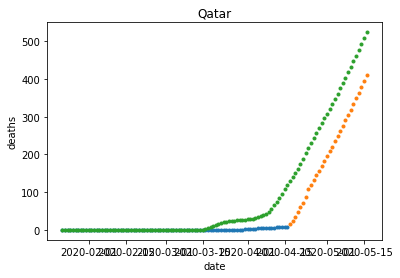

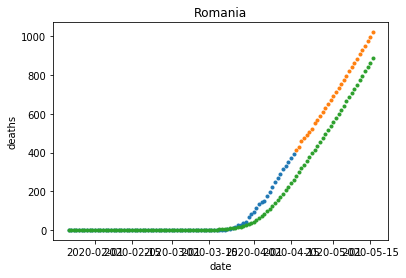

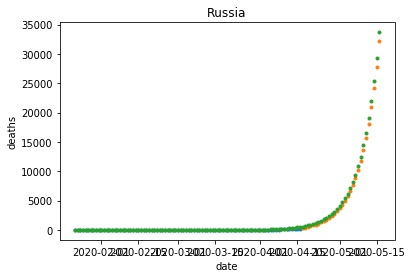

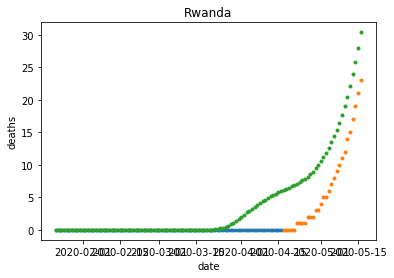

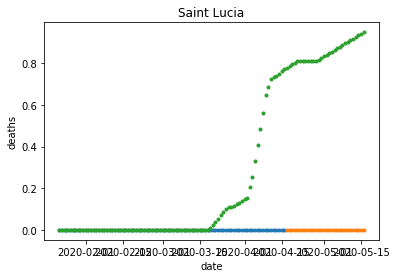

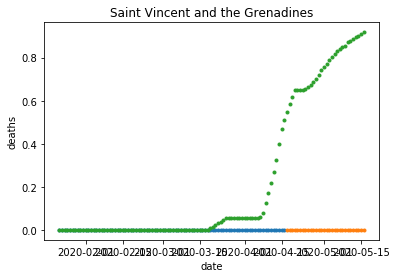

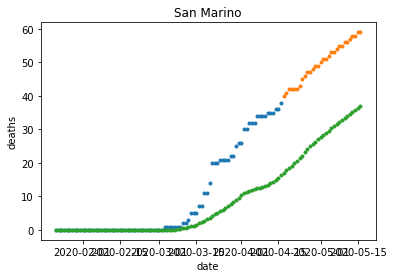

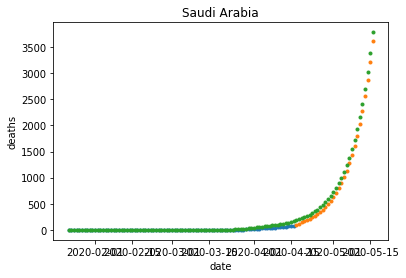

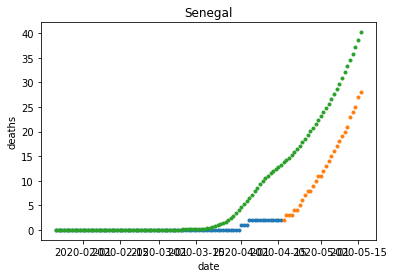

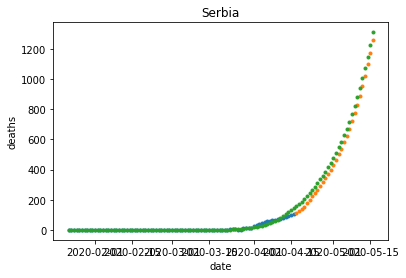

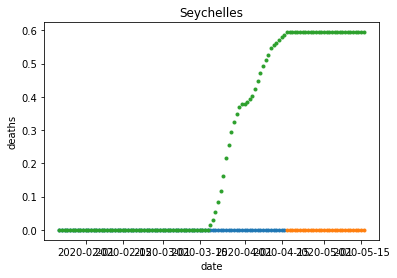

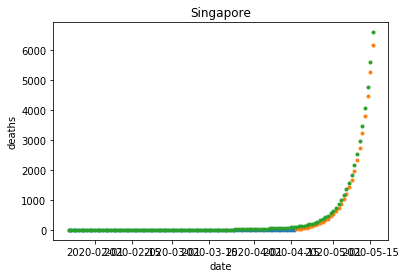

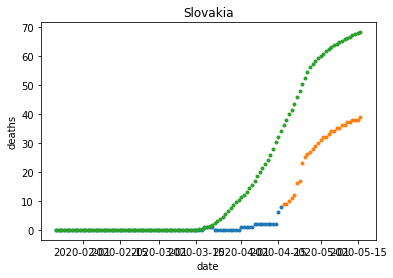

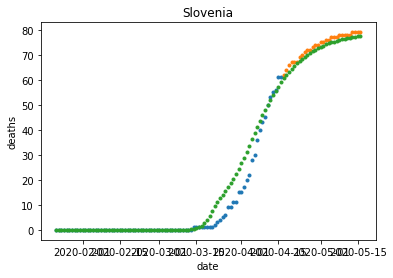

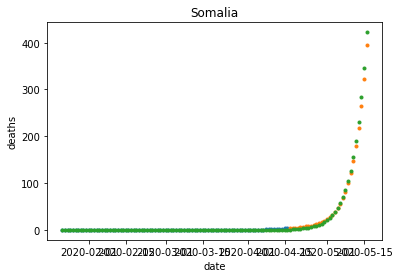

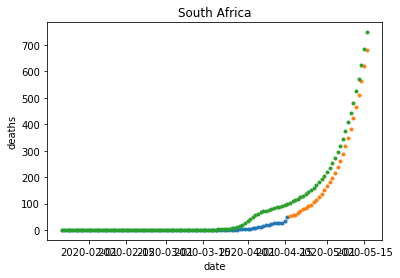

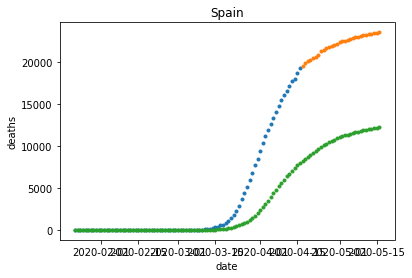

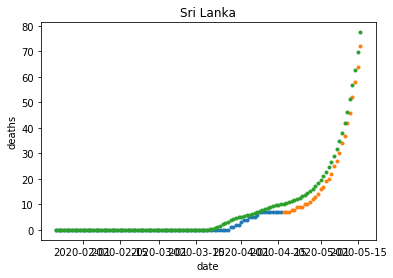

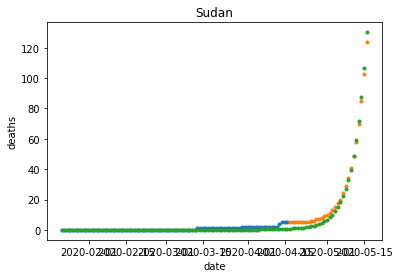

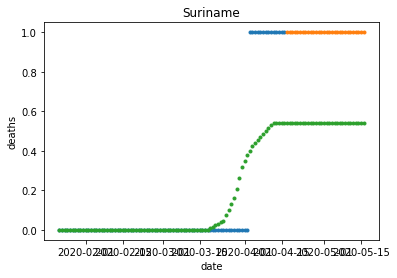

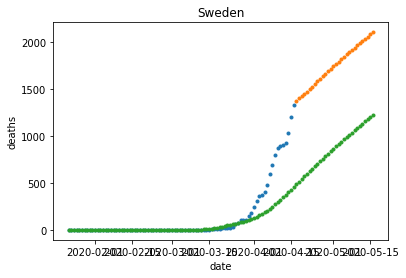

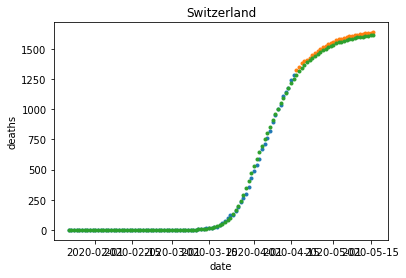

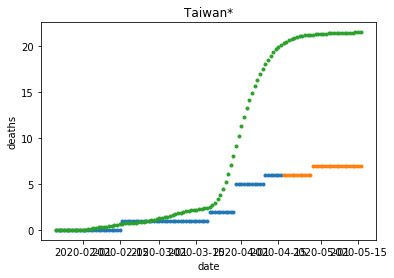

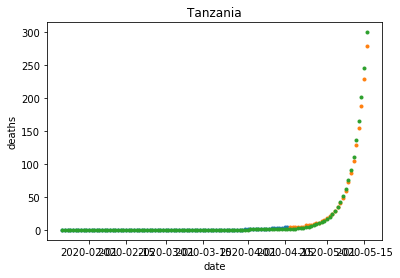

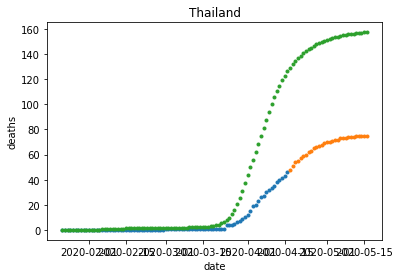

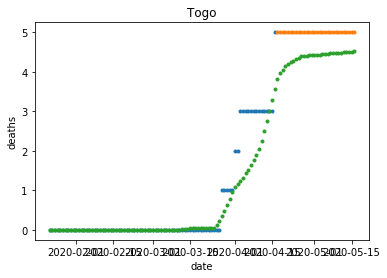

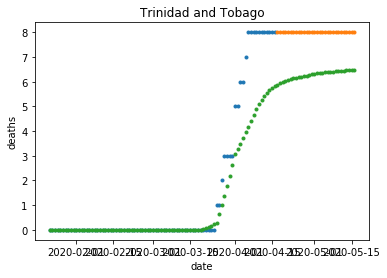

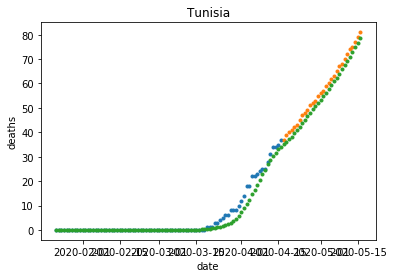

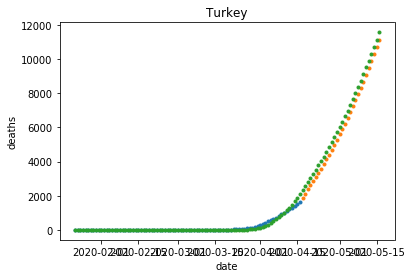

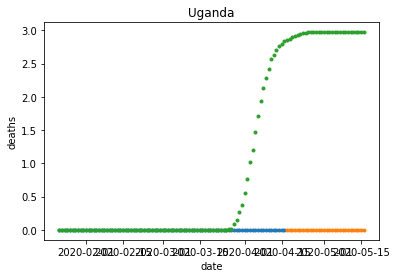

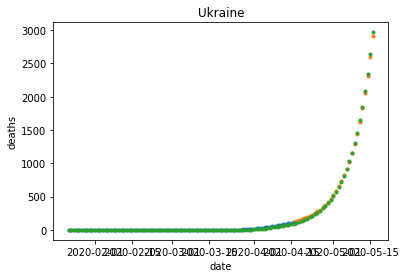

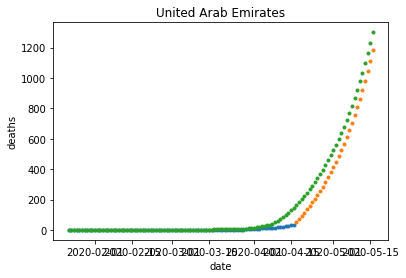

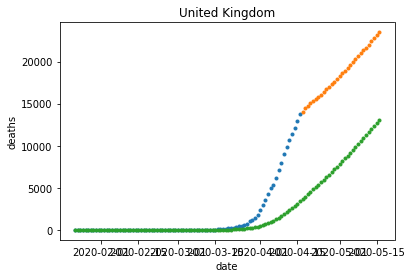

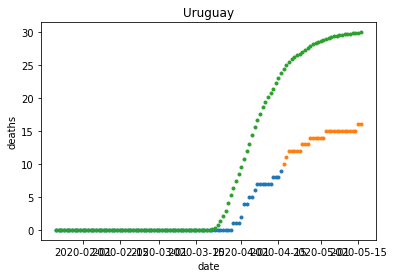

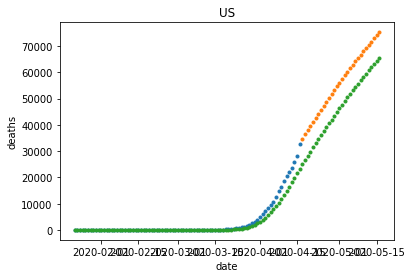

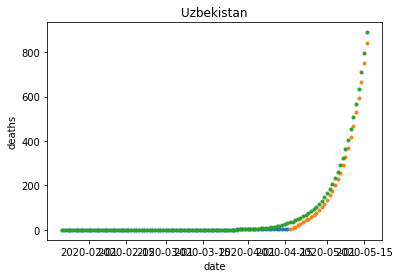

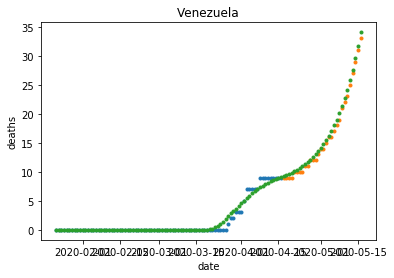

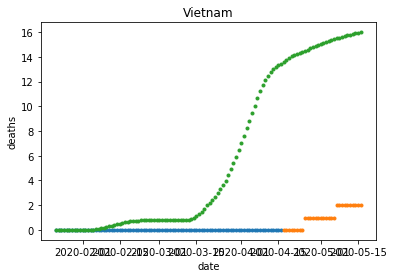

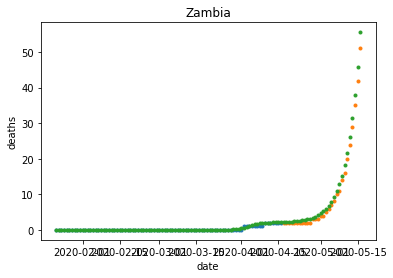

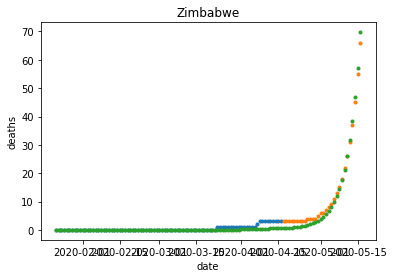

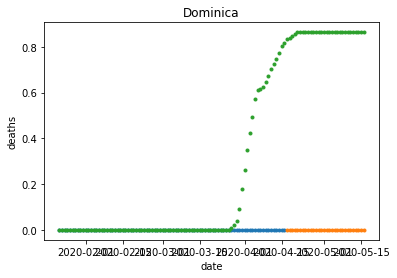

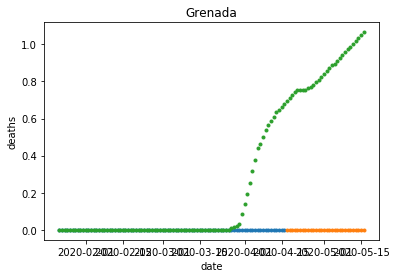

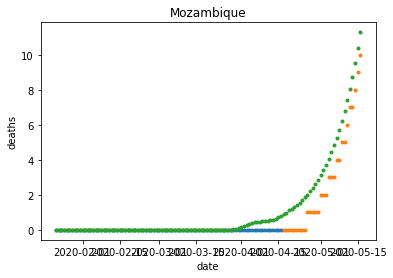

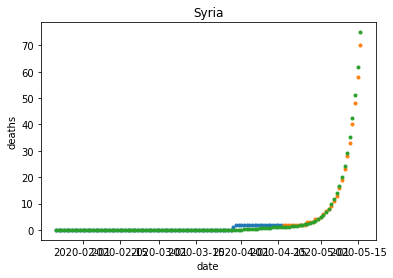

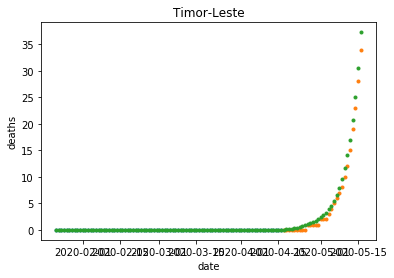

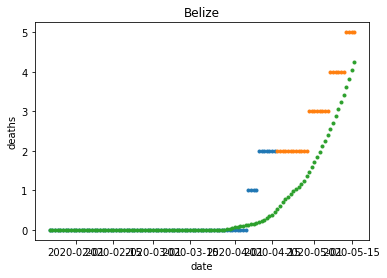

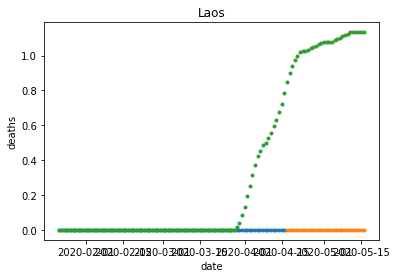

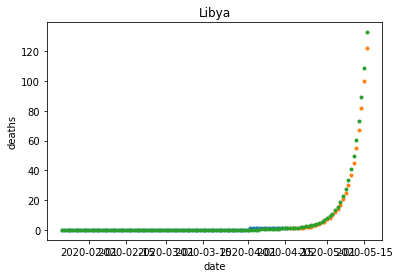

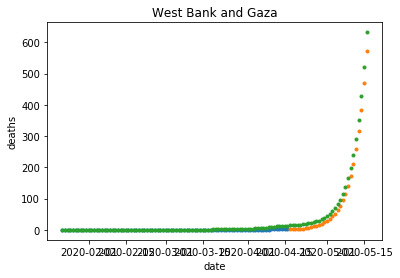

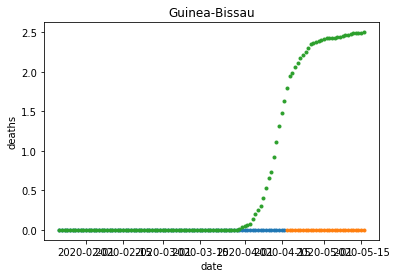

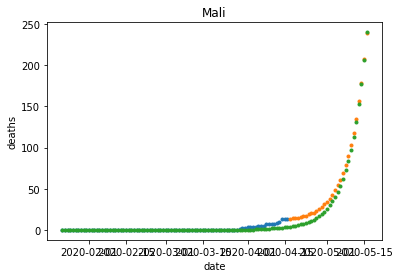

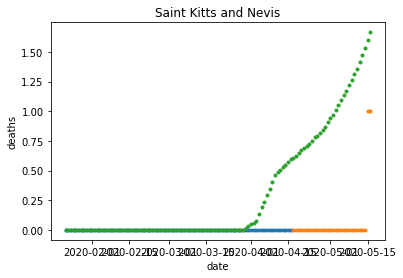

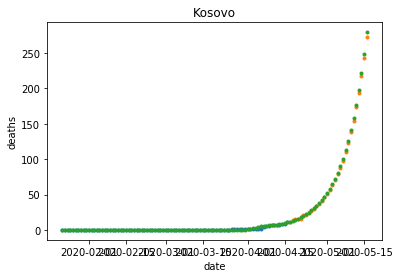

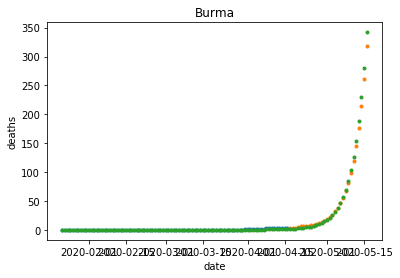

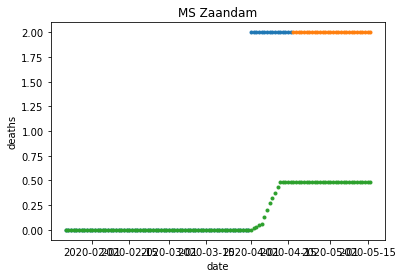

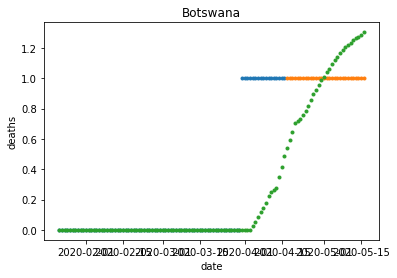

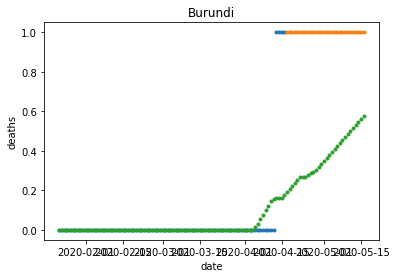

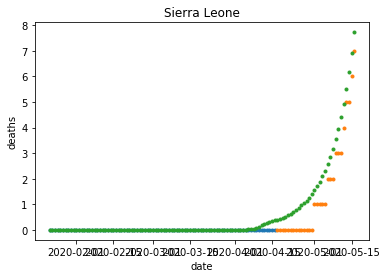

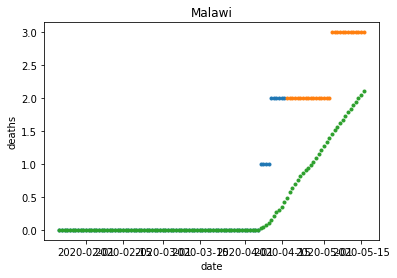

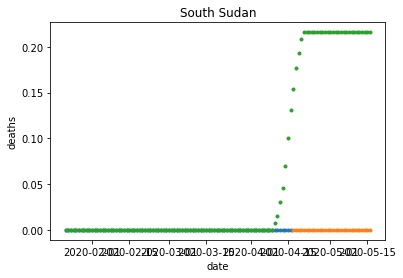

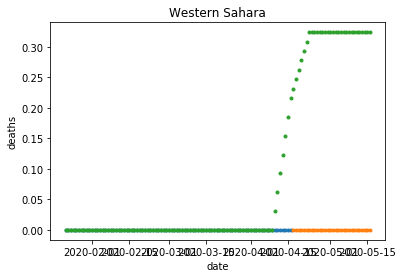

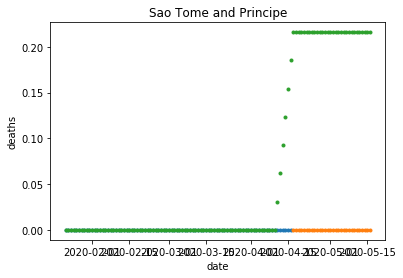

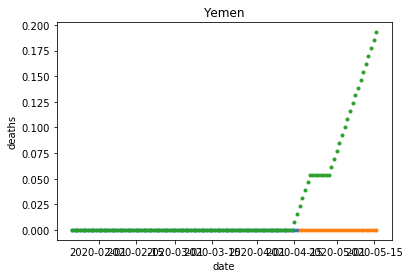

In [9]:
deaths_and_predicted = np.zeros((len(countries),len(date)+prediction_length))
death_latency, mortality = findDeathLatencyAndMortality('Switzerland')

for i in range(len(countries)): 
    country = countries[i]
    deaths_predicted, deaths, new_cases_manipulated_summed = predict_deaths(country, prediction_length, death_latency, mortality)
    for j in range(len(date)):
        deaths_and_predicted[i,j] = deaths[j]
    for j in range(prediction_length):
        deaths_and_predicted[i,j+len(date)] = deaths_predicted[j]
    """   
    fig = plt.figure()
    plt.plot(x_date[:len(date)],deaths_and_predicted[i][:len(date)],'.')
    plt.plot(x_date[len(date):len(deaths_and_predicted[i])],deaths_and_predicted[i][len(date):],'.')
    plt.plot(x_date[:len(new_cases_manipulated_summed)],new_cases_manipulated_summed,'.')
    plt.xlabel('date')
    plt.ylabel('deaths')
    plt.title(country)
    plt.show()"""

deaths_and_predicted = pd.DataFrame(data=deaths_and_predicted.T,columns=countries.to_numpy()) 

# Save to desired csv format

In [10]:
confirmed_and_predicted = confirmed_and_predicted.T
confirmed_and_predicted['Country'] = confirmed_and_predicted.index
confirmed_and_predicted = confirmed_and_predicted.reset_index()
confirmed_and_predicted = confirmed_and_predicted.drop('index',1)
# get country as the first column
cols = confirmed_and_predicted.columns.tolist()
cols = cols[-1:] + cols[:-1]
confirmed_and_predicted = confirmed_and_predicted[cols]

deaths_and_predicted = deaths_and_predicted.T
deaths_and_predicted['Country'] = deaths_and_predicted.index
deaths_and_predicted = deaths_and_predicted.reset_index()
deaths_and_predicted = deaths_and_predicted.drop('index',1)
# get country as the first column
cols = deaths_and_predicted.columns.tolist()
cols = cols[-1:] + cols[:-1]
deaths_and_predicted = deaths_and_predicted[cols]

Change Taiwan* to Taiwan

In [11]:
as_list = countries.tolist()
idx = as_list.index('Taiwan*')
as_list[idx] = 'Taiwan'
countries = as_list

Change x_date from datetime to string

In [12]:
print(df['date'])
x_date = []
for i in range(length):
    x_date.append(datetime.datetime(2020, 1, 22)+ datetime.timedelta(days=i) )
for i in range(len(x_date)):    
    x_date[i] = x_date[i].strftime('%Y-%m-%d')
x_date = np.asarray(x_date)
# t2
n = 2
path2 = r'C:\Users\stefa\OneDrive\Documents\Machine Learning\Covid-19 predictions\predictions'+r'\2day_prediction_'+x_date[len(df['date'])+n]+'.csv'
t2_prediction = pd.DataFrame(data={'Province/State': np.nan, 'Country': countries,'Target/Date': x_date[len(df['date'])+n],'N': confirmed_and_predicted.iloc[:,len(date)+n], 'D': deaths_and_predicted.iloc[:,len(date)+n]})
print(x_date[len(df['date'])])
print(len(date))
print(t2_prediction)
t2_prediction.to_csv(path2, index=False)
# t7
n = 7
path7 = r'C:\Users\stefa\OneDrive\Documents\Machine Learning\Covid-19 predictions\predictions'+r'\7day_prediction_'+x_date[len(df['date'])+n]+'.csv'
t7_prediction = pd.DataFrame(data={'Province/State': np.nan, 'Country': countries,'Target/Date': x_date[len(df['date'])+n],'N': confirmed_and_predicted.iloc[:,len(date)+n], 'D': deaths_and_predicted.iloc[:,len(date)+n]})
print(t7_prediction)
t7_prediction.to_csv(path7, index=False)
# t30
n = 30
path30 = r'C:\Users\stefa\OneDrive\Documents\Machine Learning\Covid-19 predictions\predictions'+r'\30day_prediction_'+x_date[len(df['date'])+n]+'.csv'
t30_prediction = pd.DataFrame(data={'Province/State': np.nan,'Country': countries,'Target/Date': x_date[len(df['date'])+n],'N': confirmed_and_predicted.iloc[:,len(date)+n], 'D': deaths_and_predicted.iloc[:,len(date)+n]})
print(t30_prediction)
t30_prediction.to_csv(path30, index=False)

1/22/20    1/22/20
1/23/20    1/23/20
1/24/20    1/24/20
1/25/20    1/25/20
1/26/20    1/26/20
            ...   
4/12/20    4/12/20
4/13/20    4/13/20
4/14/20    4/14/20
4/15/20    4/15/20
4/16/20    4/16/20
Name: date, Length: 86, dtype: object
2020-04-17
86
     Province/State                Country Target/Date       N      D
0               NaN            Afghanistan  2020-04-19   970.0   34.0
1               NaN                Albania  2020-04-19   543.0   26.0
2               NaN                Algeria  2020-04-19  2441.0  358.0
3               NaN                Andorra  2020-04-19   696.0   34.0
4               NaN                 Angola  2020-04-19    19.0    2.0
..              ...                    ...         ...     ...    ...
180             NaN                 Malawi  2020-04-19    18.0    2.0
181             NaN            South Sudan  2020-04-19     4.0    0.0
182             NaN         Western Sahara  2020-04-19     6.0    0.0
183             NaN  Sao Tome and Princ